<a href="https://colab.research.google.com/github/CakeNuthep/HOG_FROM_SCRATCH/blob/main/HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os, sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as iread
import tensorflow as tf
from PIL import Image
import numpy as np

In [19]:
cwd = os.getcwd()

cell = [8, 8]
incr = [8,8]
bin_num = 8
im_size = [320,320]
#normalising blocks of cells
block = [2,2]

def create_array(image_path):
	
	image = Image.open(os.path.join(cwd,image_path)).convert('L')
	image.show()
	image_array = np.asarray(image,dtype=float)
	return image_array

#uses a [-1 0 1 kernel]
def create_grad_array(image_array):
	image_array = Image.fromarray(image_array)
	if not image_array.size == im_size:
		print("resize")
		image_array = image_array.resize(im_size, resample=Image.BICUBIC)
	
	image_array = np.asarray(image_array,dtype=float)
	
	# gamma correction
	image_array = (image_array)**2.5

	# local contrast normalisation
	image_array = (image_array-np.mean(image_array))/np.std(image_array)
	max_h = im_size[1]
	max_w = im_size[0]

	grad = np.zeros([max_h, max_w])
	mag = np.zeros([max_h, max_w])
	for h,row in enumerate(image_array):
		for w, val in enumerate(row):
			if h-1>=0 and w-1>=0 and h+1<max_h and w+1<max_w:
				dy = image_array[h+1][w]-image_array[h-1][w]
				dx = row[w+1]-row[w-1]+0.0001
				grad[h][w] = np.arctan(dy/dx)*(180/np.pi)
				if grad[h][w]<0:
					grad[h][w] += 180
				mag[h][w] = np.sqrt(dy*dy+dx*dx)
	
	return grad,mag

def calculate_histogram(array,weights):
	bins_range = (0, 180)
	bins = bin_num
	hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)

	return hist

def create_hog_features(grad_array,mag_array):
	print(grad_array.shape)
	max_h = int(((grad_array.shape[0]-cell[0])/incr[0])+1)
	max_w = int(((grad_array.shape[1]-cell[1])/incr[1])+1)
	print(f"max_h: {max_h}")
	print(f"max_w: {max_w}")
	cell_array = []
	w = 0
	h = 0
	i = 0
	j = 0

	#Creating 8X8 cells
	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_hist = grad_array[h:h+cell[0],w:w+cell[1]]
			for_wght = mag_array[h:h+cell[0],w:w+cell[1]]
			
			val = calculate_histogram(for_hist,for_wght)
			# print(len(val))
			cell_array.append(val)
			j += 1
			w += incr[1]

		i += 1
		h += incr[0]
	print(len(cell_array))
	cell_array = np.reshape(cell_array,(max_h, max_w, bin_num))
	print(cell_array.shape)
	#here increment is 1

	max_h = int((max_h-block[0])+1)
	max_w = int((max_w-block[1])+1)
	print(f"max_h: {max_h}")
	print(f"max_w: {max_w}")
	block_list = []
	w = 0
	h = 0
	i = 0
	j = 0

	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_norm = cell_array[h:h+block[0],w:w+block[1]]
			mag = np.linalg.norm(for_norm)
			arr_list = (for_norm/mag).flatten().tolist()
			# print(f"length_arrlist: {len(arr_list)}")
			block_list += arr_list
			j += 1
			w += 1

		i += 1
		h += 1

	#returns a vextor array list of 288 elements
	return block_list

#image_array must be an array
#returns a 288 features vector from image array
def apply_hog(image_array):
	gradient,magnitude = create_grad_array(image_array)
	hog_features = create_hog_features(gradient,magnitude)
	hog_features = np.asarray(hog_features,dtype=float)
	# hog_features = np.expand_dims(hog_features,axis=0)

	return hog_features

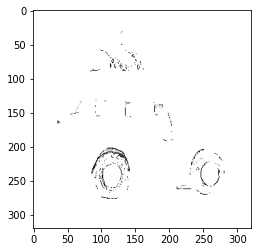

In [20]:
image_path = "/content/clay-car.jpg"
image_array = create_array(image_path)
image_array = (image_array)**2.5
image_array = Image.fromarray(image_array)

image_array = image_array.resize(im_size, resample=Image.BICUBIC)

# print(image_array.shape)
imshow(image_array,cmap='gray', vmin=0, vmax=255)

In [21]:
image_array = create_array(image_path)
final_array = apply_hog(image_array)
print(f"final_array: {final_array.shape}")

resize
(320, 320)
max_h: 40
max_w: 40
1600
(40, 40, 8)
max_h: 39
max_w: 39
final_array: (48672,)


In [22]:
final_array.shape

(48672,)

max_h: 39
max_w: 39


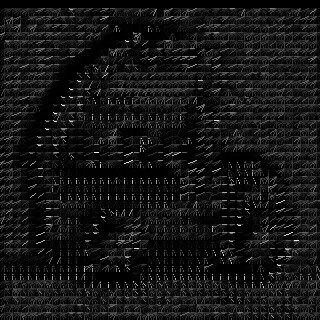

In [23]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
# Creating a black screen image using nupy.zeros function
Img = np.zeros((im_size[0],im_size[1], 1), dtype='uint8')
# Line thickness of 9 px
thickness = 1


block_invert = [cell[0] * block[0],cell[1] * block[1]]
max_w = int(((Img.shape[1]-block_invert[1])/incr[1])+1)
max_h = int(((Img.shape[0]-block_invert[0])/incr[0])+1)
print(f"max_h: {max_h}")
print(f"max_w: {max_w}")
index_final_array = 0
cell_array = []
w = 0
h = 0
i = 0
j = 0

#Creating 8X8 cells
while i<max_h:
  w = 0
  j = 0
  # print(f"i:{i}, j:{j} ,max_h:{max_h}, max_w:{max_w}")
  while j<max_w:
    step = ((cell[0]*block[0])+(cell[1]*block[1]))
    for index,result in enumerate(final_array[index_final_array:index_final_array+step]):
      row = int((index / cell[0])/2)
      colum = int((index / cell[1])%2)
      top_left = [w+(colum*cell[1]),h+(row*cell[0])]
      buttom_right = [w+(colum*cell[1])+cell[1],h+(row*cell[0])+cell[0]]
      center = [int((top_left[0] + buttom_right[0])/2),int((buttom_right[1]))]
      start_point = center

      end_point = [0,0]
      length = int(cell[0])
      angle = int((index%bin_num) * (180/bin_num))
      # White color in BGR
      color = int(255 *result) 
      end_point[0] =  int(start_point[0] + length * np.cos(angle * np.pi / 180.0));
      end_point[1] =  int(start_point[1] + length * np.sin(angle * np.pi / 180.0));
      # print(f"w: {w}, h:{h} ,index: {index}, row: {row}, colum: {colum},start_point: {start_point} ,end_point: {end_point}, angle: {angle} ,result:{result}")
      image = cv2.line(Img, start_point, end_point, color, thickness)
    j += 1
    index_final_array += step
    w += incr[0]

  i += 1
  h += incr[1]



dim = (320, 320)
# resize image
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

# Display the image
cv2_imshow(resized)